In [1]:
%env CUDA_VISIBLE_DEVICES=7
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

env: CUDA_VISIBLE_DEVICES=7


In [2]:
import copy
import torch

from utils.visualization import display_image_pair
from utils.model import read_model_config, load_model
from utils.dataset import read_dataset_config, load_dataset, Preprocessor
from utils.correspondence import compute_pck_img, compute_pck_bbox, flip_points, rescale_points

In [3]:
model_name = 'diff_add'
dataset_config = '../dataset_config.yaml'
model_config = '../eval_config.yaml'
device_type = 'cuda'
pck_threshold = 0.1

In [4]:
# Load model config
model_config = read_model_config(model_config)[model_name]

# Get model parameters
image_size = model_config.get('image_size', (512, 512))
grad_enabled = model_config.get('grad_enabled', False)
rescale_data = model_config.get('rescale_data', False)
image_range = model_config.get('image_range', (-1, 1))

# Load model
model = load_model(model_name, model_config)

# Move model to device
device = torch.device(device_type)
model.to(device)

# Load dataset config
dataset_config = read_dataset_config(dataset_config)

# Define preprocessor
preprocess = Preprocessor(image_size, image_range=image_range, rescale_data=rescale_data)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating dataset: SPair-71k


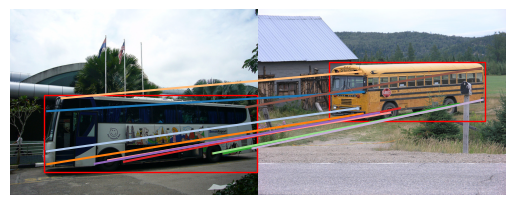

In [9]:
# Evaluate
dataset_name = list(dataset_config.keys())[0]
print(f"Evaluating dataset: {dataset_name}")
config = dataset_config[dataset_name]
dataset = load_dataset(dataset_name, config)

# Take first sample
unprocessed_sample = dataset[0]

# Use only 1 keypoint for Hedlin et al. because of time constraints
if model_name == 'hedlin':
    rand_i = torch.randint(0, unprocessed_sample['source_points'].shape[0], (1,)).item()
    unprocessed_sample['source_points'] = unprocessed_sample['source_points'][rand_i, :].unsqueeze(0)
    unprocessed_sample['target_points'] = unprocessed_sample['target_points'][rand_i, :].unsqueeze(0)

# Visualize sample
display_image_pair(unprocessed_sample, show_bbox=True)

# Preprocess sample
sample = preprocess(copy.deepcopy(unprocessed_sample))

def batchify(sample):
    batch = {}
    for key in sample:
        if key in ['source_image', 'target_image', 'source_bbox', 'target_bbox']:
            batch[key] = sample[key].unsqueeze(0)
        else:
            batch[key] = [sample[key]]
    return batch

# Batchify sample
sample = batchify(sample)

# load images on device
sample['source_image'] = sample['source_image'].to(device)
sample['target_image'] = sample['target_image'].to(device)

In [10]:
# run through model
with torch.set_grad_enabled(grad_enabled):
    predicted_points = model(sample)[0].cpu()

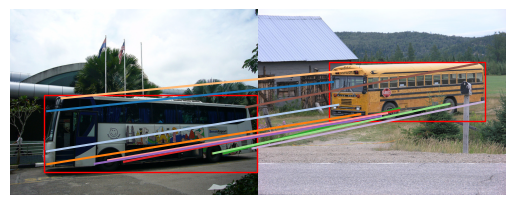

In [12]:
predicted_sample = copy.deepcopy(unprocessed_sample)
predicted_points = flip_points(predicted_points)
if rescale_data:
    predicted_points = rescale_points(predicted_points, image_size, predicted_sample['target_size'])
predicted_sample['target_points'] = predicted_points

display_image_pair(predicted_sample, show_bbox=True)

In [13]:
# calculate PCK values
target_points = unprocessed_sample['target_points']
source_points = unprocessed_sample['source_points']
target_bbox = unprocessed_sample['target_bbox']
pck_img = compute_pck_img(predicted_points, target_points, image_size, pck_threshold)
pck_bbox = compute_pck_bbox(predicted_points, target_points, target_bbox, pck_threshold)
keypoints = len(source_points)

print(f"pck_img: {pck_img / keypoints}, pck_bbox: {pck_bbox / keypoints}")

pck_img: 0.9090909090909091, pck_bbox: 0.7272727272727273


# Custom and Interactive

In [14]:
from ipyfilechooser import FileChooser
from IPython.display import display
import ipywidgets as widgets

# Create file chooser for source image
source_fc = FileChooser()
source_fc.title = '<b>Select Source Image</b>'
source_fc.filter_pattern = ['*.jpg', '*.png', '*.jpeg']

# Create file chooser for target image
target_fc = FileChooser()
target_fc.title = '<b>Select Target Image</b>'
target_fc.filter_pattern = ['*.jpg', '*.png', '*.jpeg']

# Layout file choosers side by side
file_chooser_layout = widgets.HBox([source_fc, target_fc])
display(file_chooser_layout)


In [ ]:
from PIL import Image

# Load images
source_image = Image.open(source_fc.selected)
target_image = Image.open(target_fc.selected)

# Get source and target features
source_image_processed = preprocess.process_image(source_image)
target_image_processed = preprocess.process_image(target_image)
source_features = model.get_features(source_image_processed.unsqueeze(0).to(device), [''])
target_features = model.get_features(target_image_processed.unsqueeze(0).to(device), [''])

if isinstance(source_features, list):
    source_features = source_features[0]
if isinstance(target_features, list):
    target_features = target_features[0]

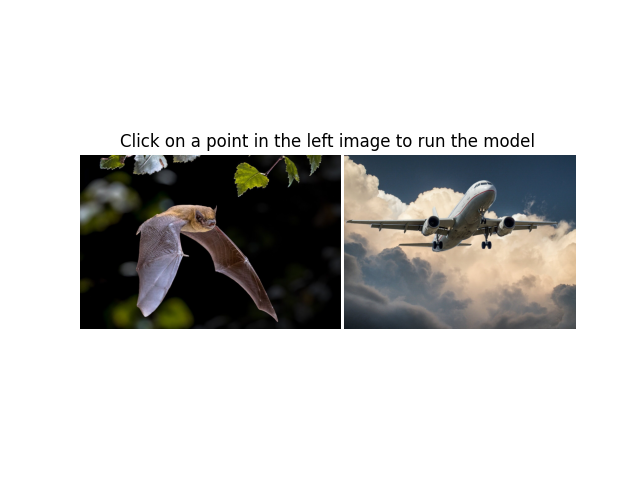

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap

class ColorPicker:
    def __init__(self, colors, num_colors, shift):
        cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=num_colors)
        self.gradient = [cmap(i / num_colors) for i in range(num_colors)]
        self.shift = shift
        self.num_colors = num_colors
        self.current_index = 0

    def __call__(self):
        color = self.gradient[self.current_index]
        self.current_index += 1
        if self.current_index >= self.num_colors:
            self.current_index = self.shift
        return color
        
# Create a color picker
colors = ["#5FA1FF", "#FF00CC", "#FFFB00"]
color_picker = ColorPicker(colors, 10, 2)

# Function to display images with optional equal height and circle drawing
def display_images(source_image, target_image, equal_height=True, padding=20, circle_radius=20):

    fig, ax = plt.subplots()
    
    # Set title
    ax.set_title('Click on a point in the left image to run the model')
   
    # Calculate aspect ratios
    source_aspect_ratio = source_image.size[0] / source_image.size[1]
    target_aspect_ratio = target_image.size[0] / target_image.size[1]

    if equal_height:
        # Set the height of both images to be the same
        new_height = source_image.size[1]

        # Calculate new widths while maintaining the aspect ratios
        source_new_width = int(new_height * source_aspect_ratio)
        target_new_width = int(new_height * target_aspect_ratio)
    else:
        # Keep original dimensions if equal_height is False
        new_height = source_image.size[1]
        source_new_width = source_image.size[0]
        target_new_width = target_image.size[0]

    # Calculate the offset for the target image
    offset = source_new_width + padding

    # Draw the images
    ax.imshow(source_image, extent=[0, source_new_width, 0, new_height])
    ax.imshow(target_image, extent=[offset, offset + target_new_width, 0, new_height])

    circles = []  # List to store circles

    def onclick(event):
        ix, iy = event.xdata, event.ydata

        # Check if the click is within the bounds of the left image
        if ix is not None and iy is not None and 0 <= ix < source_new_width and 0 <= iy < new_height:
            color = color_picker()

            # Create an underlying circle with 40% opacity
            circle = Circle((ix, iy), radius=circle_radius, color=color, alpha=0.4)
            ax.add_patch(circle)

            # Create a smaller overlying circle with 60% opacity
            circle = Circle((ix, iy), radius=circle_radius * 0.6, color=color, alpha=0.6)
            ax.add_patch(circle)

            circles.append(circle)
            plt.draw()

            # Scale the clicked point to the original image size and reverse y-axis
            x = ix / source_new_width * source_image.size[0]
            y = (1 - iy / new_height) * source_image.size[1]

            # Run the model on the clicked point
            batch = {
                'source_image': source_features,
                'target_image': target_features,
                'source_points': [torch.tensor([[y, x]])],
                'source_size': [[source_image.size[0], source_image.size[1]]],
                'target_size': [[target_image.size[0], target_image.size[1]]]
            }
            predicted_points = model.compute_correspondence(batch)[0]
            predicted_points = flip_points(predicted_points)
            if rescale_data:
                predicted_points = rescale_points(predicted_points, image_size, batch['target_size'])
            predicted_point = predicted_points[0].cpu().detach().numpy()

            # Scale the predicted point to the displayed image size and reverse y-axis
            predicted_point[0] = predicted_point[0] / target_image.size[0] * target_new_width
            predicted_point[1] = (1 - predicted_point[1] / target_image.size[1]) * new_height

            circle = Circle((predicted_point[0] + offset, predicted_point[1]), radius=circle_radius,
                            color=color, alpha=0.4)
            ax.add_patch(circle)
            circle = Circle((predicted_point[0] + offset, predicted_point[1]), radius=circle_radius * 0.6,
                            color=color, alpha=0.6)
            ax.add_patch(circle)

            # Draw a line between the clicked point and the predicted point
            ax.plot([ix, predicted_point[0] + offset], [iy, predicted_point[1]], color=color,
                    alpha=0.6)


    # Connect the click event handler
    fig.canvas.mpl_connect('button_press_event', onclick)

    # Set the axis limits to include both images
    ax.set_xlim(0, offset + target_new_width)
    ax.set_ylim(0, new_height)

    # Disable the axis labels
    ax.axis('off')

    # Show the plot
    plt.show()

display_images(source_image, target_image, equal_height=True, padding=20)